# Install all of the depedency

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4305, done.
remote: Counting objects: 100% (4305/4305), done.
remote: Compressing objects: 100% (3322/3322), done.
remote: Total 4305 (delta 1208), reused 2221 (delta 910), pack-reused 0 (from 0)
Receiving objects: 100% (4305/4305), 53.16 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.


In [2]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparin

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2024.10.0 requires cloudpickle>=3.0.0, but you have cloudpickle 2.2.1 which is incompatible.


In [4]:
!pip install protobuf==3.20.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.61.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.*,<6.0.0.dev0,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
google-ai-generativelanguage 0.6.10 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.19.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-aiplatform 1.71.1 requires protobuf!=4.21.0,!=4.21.1,

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

# Utils

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.5)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Load image using roboflow in TFRecord format

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wo0ILZ2EdiUJKy9Ae5bx")
project = rf.workspace("tes-m14gd").project("capstone-foodlabel-ypujk")
version = project.version(2)
dataset = version.download("tensorflow")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.0 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to capstone-foodlabel-2 in tensorflow:: 100%|██████████| 250/250 [00:00<00:00, 4348.18it/s]


# Load the downloaded items


In [8]:
import pandas as pd
import numpy as np
import os

# ... (other imports and functions)

# Path to your train folder
train_image_dir = '/content/capstone-foodlabel-2/train/'

# Load annotations
annotations_df = pd.read_csv(os.path.join(train_image_dir, '_annotations.csv'))

# Initialize lists to store images and bounding boxes
train_images_np = []
gt_boxes = []

# Loop through each row in the annotations DataFrame
for index, row in annotations_df.iterrows():
    # Load image into NumPy array and append to train_images_np
    image_path = os.path.join(train_image_dir, row['filename'])
    image_np = load_image_into_numpy_array(image_path)
    train_images_np.append(image_np)

    # Get image dimensions
    image_height, image_width, _ = image_np.shape

    # Extract and normalize bounding box coordinates
    box = np.array([[row['ymin'] / image_height,
                     row['xmin'] / image_width,
                     row['ymax'] / image_height,
                     row['xmax'] / image_width]], dtype=np.float32)
    gt_boxes.append(box)

# Now you have train_images_np and gt_boxes with normalized coordinates

In [9]:
for gt_box in gt_boxes:
  print(gt_box)

[[0.24375  0.178125 0.765625 0.809375]]
[[0. 0. 1. 1.]]
[[0.25625  0.146875 0.925    0.540625]]
[[0.271875 0.353125 0.740625 0.778125]]
[[0.221875 0.078125 0.65     0.890625]]
[[0.       0.0125   1.       0.978125]]
[[0.165625 0.06875  0.809375 0.946875]]
[[0.275   0.24375 0.75    0.78125]]
[[0.471875 0.21875  0.675    0.8875  ]]
[[0.471875 0.08125  0.634375 0.79375 ]]
[[0.459375 0.13125  0.65     0.865625]]
[[0.125    0.328125 0.93125  0.7125  ]]
[[0.421875 0.275    0.675    0.7875  ]]
[[0. 0. 1. 1.]]
[[0.246875 0.30625  0.834375 0.834375]]
[[0. 0. 1. 1.]]
[[0.00625  0.009375 0.996875 1.      ]]
[[0.096875 0.18125  0.846875 0.809375]]
[[0.24375  0.       0.653125 0.809375]]
[[0.1375   0.165625 0.73125  0.85625 ]]
[[0.075    0.31875  0.928125 0.796875]]
[[0.225    0.228125 0.765625 0.803125]]
[[0.19375  0.165625 0.834375 0.846875]]
[[0.109375 0.215625 0.81875  0.825   ]]
[[0.33125  0.26875  0.609375 0.828125]]
[[0.209375 0.321875 0.84375  0.721875]]
[[0.2375   0.16875  0.740625 0.78437

# Prepare data for training

In [10]:
label_class_id = 1
num_classes = 1

category_index = {label_class_id:{
    'id'  : label_class_id,
    'name': 'nutrition-label'
}}
print(category_index[label_class_id])
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


{'id': 1, 'name': 'nutrition-label'}
Done prepping data.


# Visualize the data

Download checkpoint and pretrained weight


*   In this project we want to use ssd-mobilenet-v2- 320x320 because it is compatible to mobile devices
*   We are going to get the pretrained weight and the feature extractor



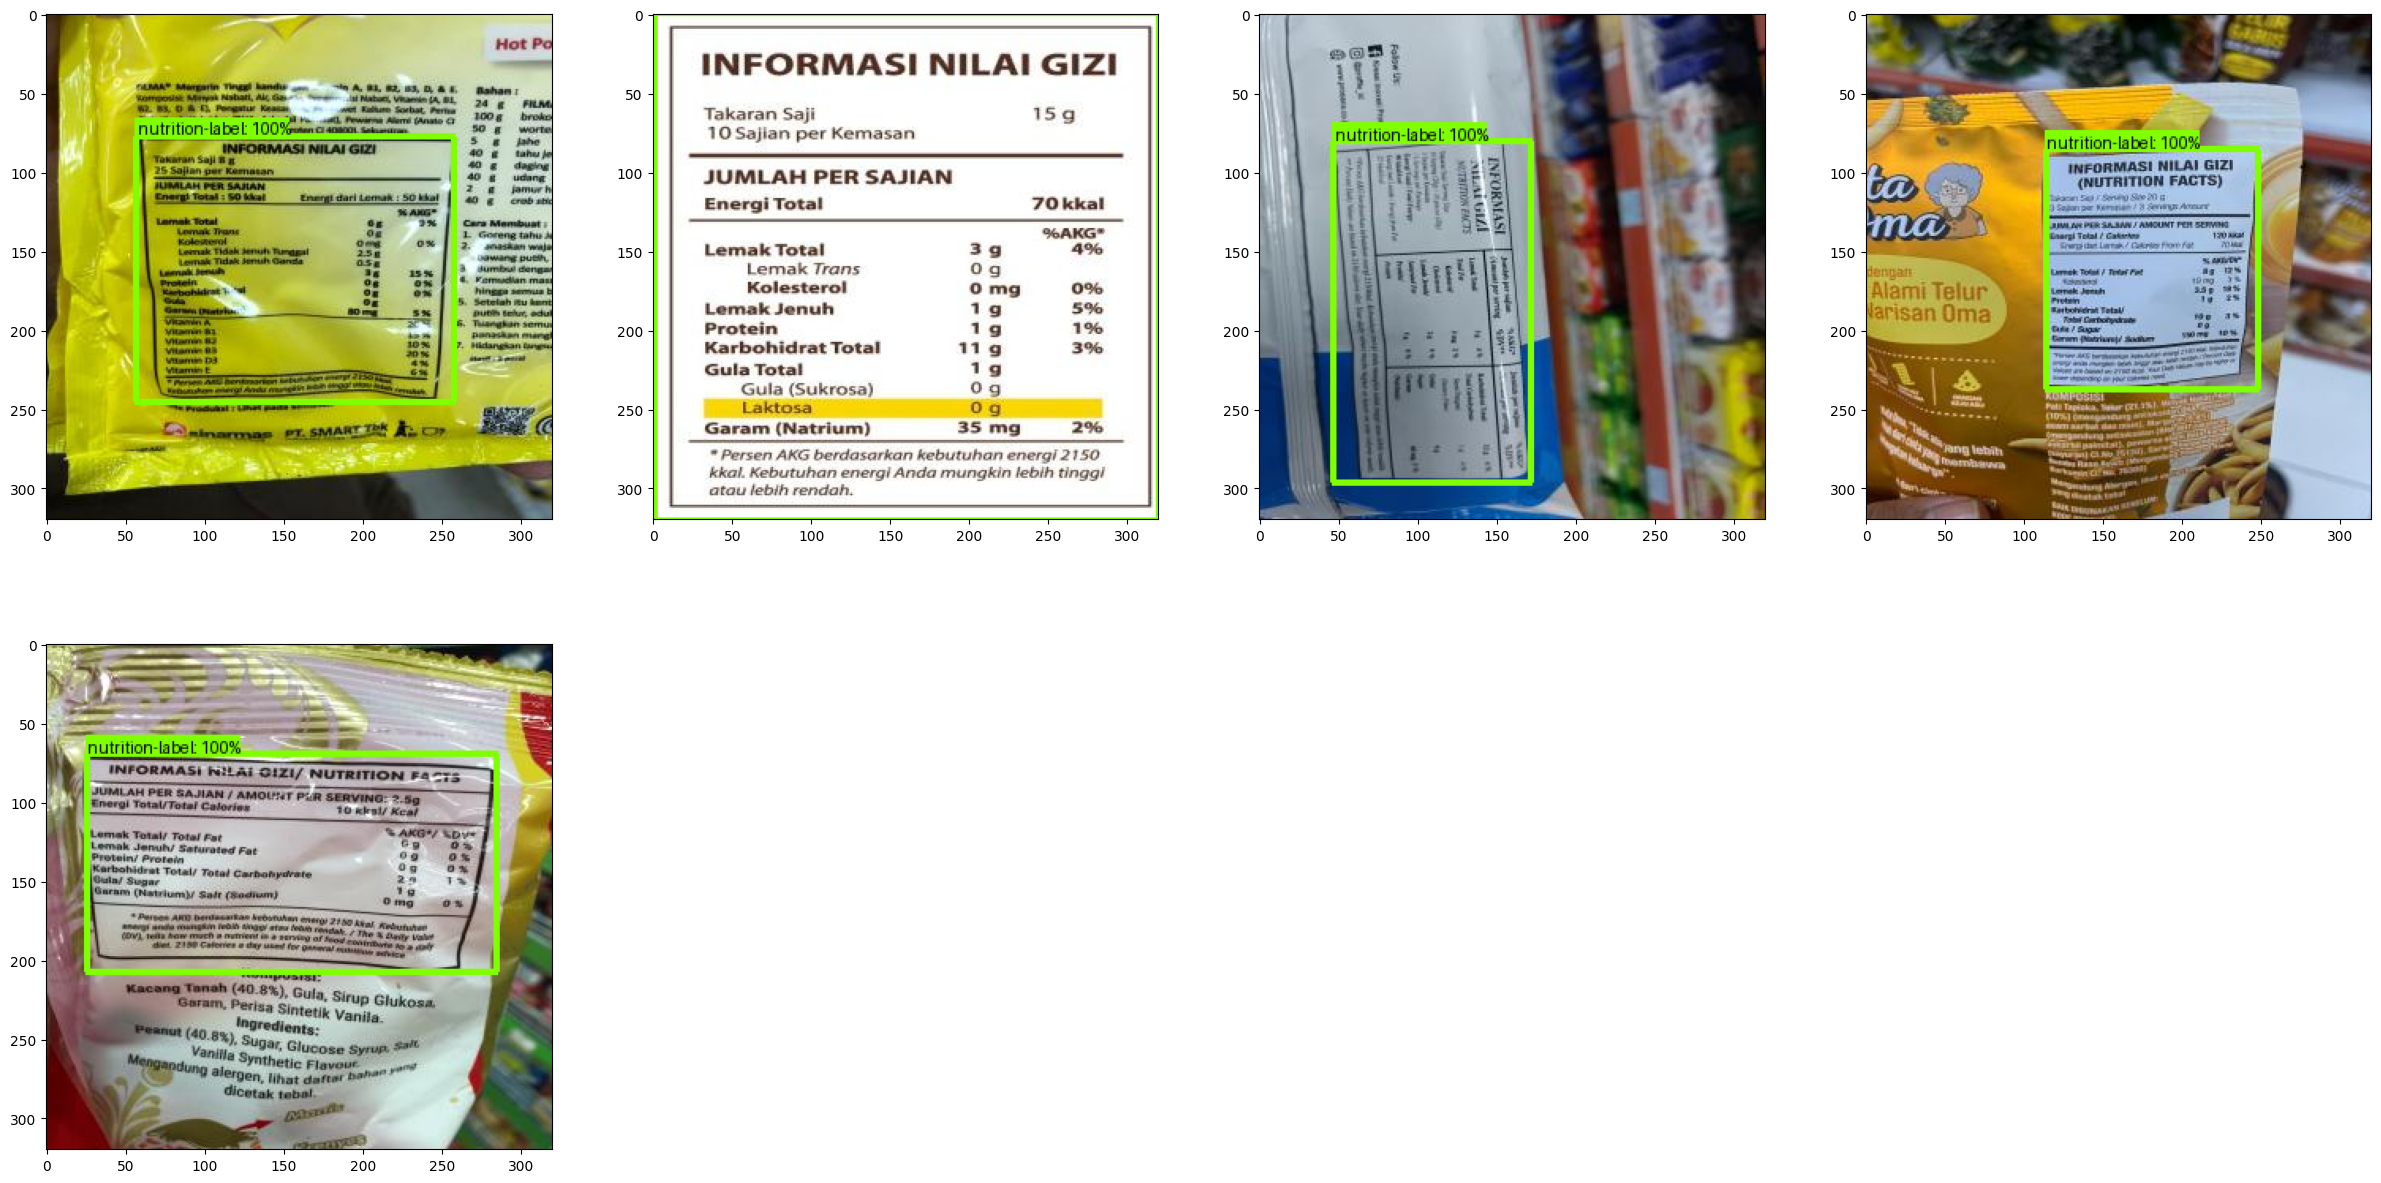

In [11]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 4, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

# Download the checkpoint containing the pre-trained weight


*   We are going to use SSD-MobileNet-V2-320x320 because it is compatible to mobile devices
*   We are going to get the pretrained weights like the feature extractor and box.predictor



In [12]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-11-26 14:30:58--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.69.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  17.2MB/s    in 1.1s    

2024-11-26 14:30:59 (17.2 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



# Configure the model

In [13]:
tf.keras.backend.clear_session()



# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'


# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)


# See what configs looks like
configs

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [14]:
model_config = configs['model']

model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 320
      width: 320
    }
  }
  feature_extractor {
    type: "ssd_mobilenet_v2_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 3.9999998989515007e-05
        }
      }
      initializer {
        random_normal_initializer {
          mean: 0.0
          stddev: 0.009999999776482582
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    use_depthwise: true
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
      additional_layer_depth: 128
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
 

In [15]:
model_config.ssd.num_classes=num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 320
      width: 320
    }
  }
  feature_extractor {
    type: "ssd_mobilenet_v2_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 3.9999998989515007e-05
        }
      }
      initializer {
        random_normal_initializer {
          mean: 0.0
          stddev: 0.009999999776482582
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    use_depthwise: true
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
      additional_layer_depth: 128
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
  

In [16]:
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# As we want to train the classification head from scratch therefore

In [17]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

In [18]:
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# For tflite conversion

In [19]:
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Initialize the weight

In [20]:
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


# Finetuning

In [21]:
tf.keras.backend.set_learning_phase(True)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [22]:
#hyperparams
batch_size = 5
learning_rate = 0.15
num_batches = 1000

In [23]:
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

In [24]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

In [25]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

In [26]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 100 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!
batch 0 of 1000, loss=1.4238622
batch 100 of 1000, loss=0.4750929
batch 200 of 1000, loss=0.47506407
batch 300 of 1000, loss=0.46194375
batch 400 of 1000, loss=0.27580696
batch 500 of 1000, loss=0.38418016
batch 600 of 1000, loss=0.25336045
batch 700 of 1000, loss=0.41367555
batch 800 of 1000, loss=0.34087533
batch 900 of 1000, loss=0.343747
Done fine-tuning!
Checkpoint saved!


# Test finetuned model

In [27]:
import glob

test_image_dir = '/content/capstone-foodlabel-2/test/'
test_images_np = []

# Get a list of all JPG files in the directory
image_paths = glob.glob(os.path.join(test_image_dir, '*.jpg'))

# Load images into a numpy array
for image_path in image_paths:
    print(image_path)
    test_images_np.append(np.expand_dims(
        load_image_into_numpy_array(image_path), axis=0))

print(f"Loaded {len(test_images_np)} images.")

/content/capstone-foodlabel-2/test/IMG_1067_png.rf.1c8074bff394c0436196e5dc75f072af.jpg
/content/capstone-foodlabel-2/test/IMG_1229_png.rf.d14ca8ac241d17577bbcc46502394454.jpg
/content/capstone-foodlabel-2/test/IMG_1217_png.rf.e9833431e05888282cc0a30d07b8dcf8.jpg
/content/capstone-foodlabel-2/test/pkg-2410-q-1638498547_jpg.rf.272a5775913eb216299fc8bb2d5bc717.jpg
/content/capstone-foodlabel-2/test/nutfact-1648811566_jpg.rf.b221a7227b12078945c35721b8304cb6.jpg
/content/capstone-foodlabel-2/test/IMG_1218_png.rf.d715d745fe8c8f9ae1b62e646d941ddc.jpg
/content/capstone-foodlabel-2/test/IMG_1082_png.rf.d03c735ae92d296867e35b24b02d16a5.jpg
/content/capstone-foodlabel-2/test/IMG_1085_png.rf.bb551c8bf7f609bd3c666341afca9c02.jpg
/content/capstone-foodlabel-2/test/20240515_163133_png.rf.e2d2864492dd7df2451b0280549274c9.jpg
/content/capstone-foodlabel-2/test/20240515_163153_png.rf.26d52e9510df1fb5992e1cae833aeccc.jpg
/content/capstone-foodlabel-2/test/IMG_3553_png.rf.99a4fa019e3f8617c56c5cab4c516a2f

# Preprocess, predict, and post process an image

In [28]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)


    detections = detection_model.postprocess(prediction_dict, shapes)


    return detections

In [29]:
!mkdir gif_dir

In [30]:
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="/content/gif_dir/" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [31]:
# TEST CODE

print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# compare with expected bounding boxes
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

74
(4,)

False
False
False


In [32]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
label_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(label_detected)

8.438818565400844


Frame 0


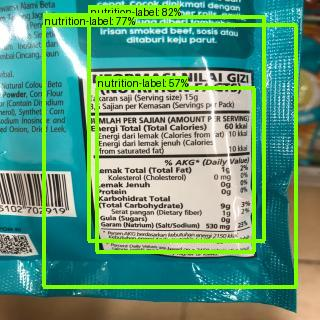


Frame 5


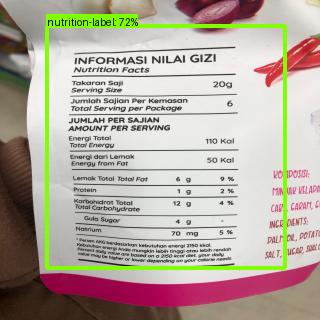


Frame 10


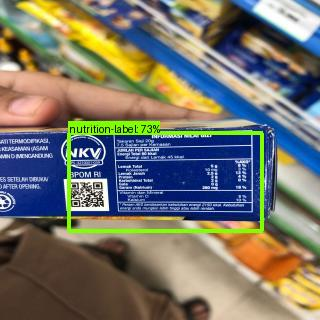

In [33]:
print('Frame 0')
display(IPyImage('/content/gif_dir/000.jpg'))
print()
print('Frame 5')
display(IPyImage('/content/gif_dir/001.jpg'))
print()
print('Frame 10')
display(IPyImage('/content/gif_dir/002.jpg'))

# Test .tflite model

In [34]:
!ls

capstone-foodlabel-2  sample_data
gif_dir		      ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8
models		      ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
output


In [35]:
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

2024-11-26 14:32:19.214874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 14:32:19.214925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 14:32:19.216185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 14:32:20.205576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-26 14:32:23.708259: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I1126 14:32:26.879693 133

In [36]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

2024-11-26 14:32:56.920924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 14:32:56.920966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 14:32:56.922142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 14:32:57.881510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-26 14:32:59.774029: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-26 14:33:08.77586

In [37]:

# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  boxes = boxes[0]  # Get the first element (assuming it's a batch of 1)
  classes = classes[0][:boxes.shape[0]].astype(np.uint32) + label_id_offset
  scores = scores[0, :]  # Get the first element (assuming it's a batch of 1)

  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    boxes, classes, scores = detect(interpreter, input_tensor)

    # Ensure boxes, classes, and scores have the expected shapes
    boxes = boxes[0]  # Get the first element assuming boxes is (1, N, 4)
    classes = classes[0].astype(np.uint32) + label_id_offset  # Get the first element and add offset
    scores = scores[0]  # Get the first element assuming scores is (1, N)

    # Validate shapes before calling plot_detections
    print("boxes shape:", boxes.shape)
    print("classes shape:", classes.shape)
    print("scores shape:", scores.shape)

    plot_detections(
        test_images_np[i][0],
        boxes,
        classes,
        scores,
        category_index,
        figsize=(15, 20),
        image_name="gif_frame_" + ('%02d' % i) + ".jpg"
    )


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [40]:
from google.colab import files
files.download('tflite/model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>